In [42]:
import pvdeg
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import os
import time

PYSAM configs contained in the repo were originally using analysis_period = 25, so we would get 8760*25 outputs for the temporal results, this is wasteful because we are using TMY data so it would repeat the data and produce identical outputs between years. Computation time is linearly proportional to number of years as shown in the plot below.

We can save 25x on compute but setting the analysis_period = 1

In [28]:
weather_db = "NSRDB"
weather_arg = {
    "satellite": "Americas",
    "names": "TMY",
    "NREL_HPC": True,
    "attributes": pvdeg.pysam.INSPIRE_NSRDB_ATTRIBUTES,
}

geo_weather, geo_meta = pvdeg.weather.get(
    weather_db, geospatial=True, **weather_arg)

/home/tford/.conda-envs/geospatial/lib/python3.9/site-packages/xarray/core/dataset.py:277: UserWarning: The specified chunks separate the stored chunks along dimension "phony_dim_1" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [34]:
geo_meta[geo_meta["state"] == "Colorado"]

,latitude,longitude,altitude,tz,country,state,county,wind_height
389874,38.570000,-109.059998,2494,-7,United States,Colorado,Mesa,2
389875,38.529999,-109.059998,2189,-7,United States,Colorado,Mesa,2
389876,38.490002,-109.059998,2300,-7,United States,Colorado,Montrose,2
389877,38.450001,-109.059998,2349,-7,United States,Colorado,Montrose,2
389878,38.410000,-109.059998,2330,-7,United States,Colorado,Montrose,2
...,...,...,...,...,...,...,...,...
560848,37.169998,-102.059998,1124,-7,United States,Colorado,Baca,2
560849,37.130001,-102.059998,1125,-7,United States,Colorado,Baca,2
560850,37.090000,-102.059998,1085,-7,United States,Colorado,Baca,2
560851,37.049999,-102.059998,1080,-7,United States,Colorado,Baca,2


we will use the first point in colorado
- gid = 389874

In [38]:
geo_meta.loc[gid]

latitude               38.57
longitude        -109.059998
altitude                2494
tz                        -7
country        United States
state               Colorado
county                  Mesa
wind_height                2
Name: 389874, dtype: object

In [40]:
confs = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

times = {}
gid = 389874

for conf in confs:

    # convert to single site (weather dataframe, meta dict)
    weather_df = geo_weather.sel(gid=gid).to_dataframe()
    meta = geo_meta.loc[gid].to_dict()

    # rename variables to align with pvdeg/duramat standards
    weather_df = pvdeg.weather.map_weather(weather_df)
    meta = pvdeg.weather.map_meta(meta)

    one_yr_path = f"/home/tford/dev/InSPIRE-1yr/Studies/USMap_Doubleday_2024/SAM/{conf}/{conf}_pvsamv1.json" # these have an analysis period of 1 year
    inspire_path = f"/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/{conf}/{conf}_pvsamv1.json" # these have an analysis period of 25 years

    short_start = time.time()
    
    short = pvdeg.pysam.inspire_ground_irradiance(
        weather_df=weather_df,
        meta=meta,
        config_files={'pv':one_yr_path}
    )

    short_end = time.time()
    long_start = time.time()
    
    long = pvdeg.pysam.inspire_ground_irradiance(
        weather_df=weather_df,
        meta=meta,
        config_files={'pv':inspire_path}
    )

    long_end = time.time()

    short_duration = short_end - short_start
    long_duration = long_end - long_start

    times[conf] = {
        "1yr":short_duration,
        "25yr":long_duration
    }
    
    print(f"{conf} done")


01 done
02 done
03 done
04 done
05 done
06 done
07 done
08 done
09 done
10 done


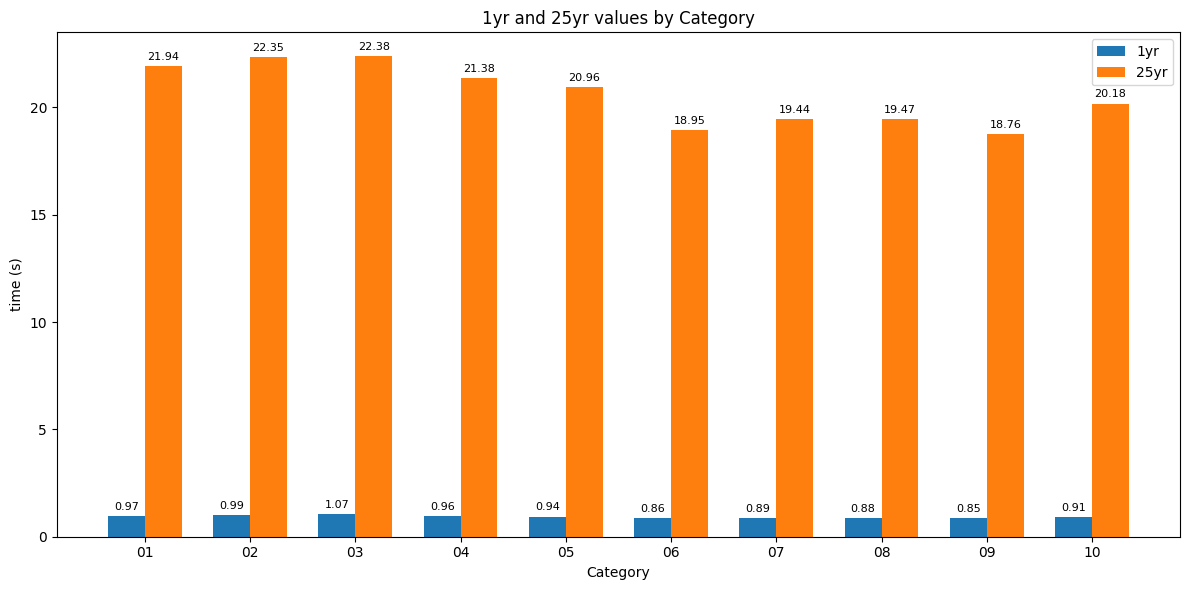

In [45]:
data = times

categories = list(data.keys())
yr_1 = [data[cat]['1yr'] for cat in categories]
yr_25 = [data[cat]['25yr'] for cat in categories]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, yr_1, width, label='1yr')
bars2 = ax.bar(x + width/2, yr_25, width, label='25yr')

# Labels and title
ax.set_xlabel('Category')
ax.set_ylabel('time (s)')
ax.set_title('1yr and 25yr values by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display values on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

run single location and compare values to check that we are getting the same results

In [46]:
conf = "01"

# convert to single site (weather dataframe, meta dict)
weather_df = geo_weather.sel(gid=gid).to_dataframe()
meta = geo_meta.loc[gid].to_dict()

# rename variables to align with pvdeg/duramat standards
weather_df = pvdeg.weather.map_weather(weather_df)
meta = pvdeg.weather.map_meta(meta)

one_yr_path = f"/home/tford/dev/InSPIRE-1yr/Studies/USMap_Doubleday_2024/SAM/{conf}/{conf}_pvsamv1.json" # these have an analysis period of 1 year
inspire_path = f"/home/tford/dev/InSPIRE/Studies/USMap_Doubleday_2024/SAM/{conf}/{conf}_pvsamv1.json" # these have an analysis period of 25 years

short = pvdeg.pysam.inspire_ground_irradiance(
    weather_df=weather_df,
    meta=meta,
    config_files={'pv':one_yr_path}
)

long = pvdeg.pysam.inspire_ground_irradiance(
    weather_df=weather_df,
    meta=meta,
    config_files={'pv':inspire_path}
)


In [52]:
short.identical(long)

True